# Layout

+ Searching text for keywords
+ Distribution of terms
+ Correlation
+
+ From last year:
    + Word frequencies
    + Conditional frequencies
    + Statistically significant collocations
    + Distinguishing or Important words and phrases (Wordls!)
        + tfidf
    + POS-tagged words and phrases
    + Lemmatized words and phrases
        + stemmers
    + Dictionary-based annotations.

+ divergences
    + kale

+ Sources
    + US senate press releases
        + e.g. [http://www.reid.senate.gov/press_releases](http://www.reid.senate.gov/press_releases)
    + Tumblr
    + Literature

# Week 2 - Corpus Linguistics

Intro stuff

For this notebook we will be using the following packages

In [1]:
import nltk
import pandas
import matplotlib.pyplot as plt
%matplotlib inline  

# Getting our corpuses

To get started we will need some targets, lets start by downloading one of the corpuses from `nltk`. Lets take a look at how that works.

first we can get a list of corpuses avaible from the Gutenburg corpus

In [2]:
print(nltk.corpus.gutenberg.fileids())
print(len(nltk.corpus.gutenberg.fileids()))

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']
18


We can also look at the individual works

In [3]:
nltk.corpus.gutenberg.raw('shakespeare-macbeth.txt')[:1000]

"[The Tragedie of Macbeth by William Shakespeare 1603]\n\n\nActus Primus. Scoena Prima.\n\nThunder and Lightning. Enter three Witches.\n\n  1. When shall we three meet againe?\nIn Thunder, Lightning, or in Raine?\n  2. When the Hurley-burley's done,\nWhen the Battaile's lost, and wonne\n\n   3. That will be ere the set of Sunne\n\n   1. Where the place?\n  2. Vpon the Heath\n\n   3. There to meet with Macbeth\n\n   1. I come, Gray-Malkin\n\n   All. Padock calls anon: faire is foule, and foule is faire,\nHouer through the fogge and filthie ayre.\n\nExeunt.\n\n\nScena Secunda.\n\nAlarum within. Enter King Malcome, Donalbaine, Lenox, with\nattendants,\nmeeting a bleeding Captaine.\n\n  King. What bloody man is that? he can report,\nAs seemeth by his plight, of the Reuolt\nThe newest state\n\n   Mal. This is the Serieant,\nWho like a good and hardie Souldier fought\n'Gainst my Captiuitie: Haile braue friend;\nSay to the King, the knowledge of the Broyle,\nAs thou didst leaue it\n\n   Cap. 

All the listed works have been nicely marked up and classified for us so we can do much better than just looking at raw text.

In [4]:
print(nltk.corpus.gutenberg.words('shakespeare-macbeth.txt'))
print(nltk.corpus.gutenberg.sents('shakespeare-macbeth.txt'))

['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', ...]
[['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', 'William', 'Shakespeare', '1603', ']'], ['Actus', 'Primus', '.'], ...]


If we want to do some analysis we can start by simply counting the number of times each word occurs.

In [5]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

countedWords = wordCounter(nltk.corpus.gutenberg.words('shakespeare-macbeth.txt'))
countedWords

,count,word
0,2,kingdomes
1,63,on
2,1,stone
3,1,fact
4,1,consent
5,1,resolution
6,1,lid
7,1,wayting
8,1,sell
9,1,chestnuts


Notice how `wordCounter()` is not a very complicated function. That is because the hard parts have already been done by `nltk`. If we were using unprocessed text we would have to tokenize and determine what to do with the non-word characters.

Lets plot our counts and see what it looks like.

First we need to sort the words by count.

In [6]:
#Doing this in place as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords

,count,word
1364,1962,","
3306,1235,.
3278,650,the
2365,637,'
1679,546,and
475,477,:
1812,384,to
1895,348,i
322,338,of
1872,241,?


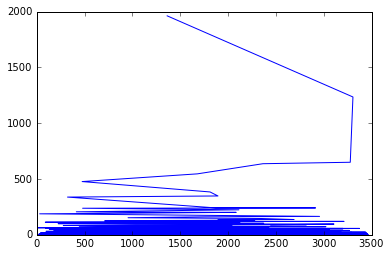

In [7]:
plt.plot(countedWords['count'])